# Linear models

## Index
1. [Import data](#import_data)
2. [Linear regression](#linear_regression)
    1. [Least squares](#least_squares)

## Import data <a id="import_data" />

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
import matplotlib.pyplot as plt


In [2]:
def get_data():
    curr_dir = os.getcwd()
    data_path = os.path.join(curr_dir, "./datasets/Advertising.csv")
    advert_data = pd.read_csv(data_path)
    advert_data.head()
    y = advert_data.loc[:,'sales']
    X = advert_data.loc[:,['TV', 'radio', 'newspaper']]
    return X, y

In [3]:
def get_train_test_data(X, y):
    X.insert(loc=0, column='intercept', value=pd.Series(1, index=X.index))
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, shuffle = True,          random_state = 42)
    return X_train, X_test, y_train, y_test

## Linear regression <a id="linear_regression" />



### Least squares

Find the regressors by using method of least squares. <br/>
$ \hat{y} = A^Tx, \qquad \hat{y} \in R, A \in R ^{k \times 1}, x \in R ^{k \times 1} $ <br/>
$ \text{MSE} = \sum\limits_{i=0}^n(y_i - \hat{y}_i)^2 $ <br/> 
$ \text{To minimize MSE}, \quad  \frac{\partial{MSE}}{\partial{A}} = 0 $ <br/>
$ \implies A = (X^TX)^{-1}(X^TY)$

In [4]:
X, y = get_data()
X_train, X_test, y_train, y_test = get_train_test_data(X, y)

In [5]:
# method of least-square
def least_square(X_train, y_train):
    pos_semi = X_train.T.dot(X_train)
    A = pd.DataFrame(np.linalg.pinv(pos_semi), 
    pos_semi.index, pos_semi.columns).dot(X_train.T.dot(y_train))
    return A

In [6]:
def get_mse(X, y, A):
    return y.subtract(X.dot(A)).pow(2).mean()

In [7]:
# Get regressors
A = least_square(X_train, y_train)
# MSE-train
mse_train = get_mse(X_train, y_train, A)
# MSE-test
mse_test = get_mse(X_test, y_test, A)
print(A)
print(mse_train, mse_test)

intercept    2.979067
TV           0.044730
radio        0.189195
newspaper    0.002761
dtype: float64
2.7051294230814134 3.174097353976193


In [8]:
X, y = get_data()

In [9]:
# normalize values
def normalize(val,min_val,max_val):
    if(min_val < max_val):
        return (val-min_val)/(max_val-min_val)
    return val
def normalize_feature(feature_series):
    min_val = feature_series.min()
    max_val = feature_series.max()
    return feature_series.apply(normalize, args=(min_val, max_val))

X_normalised = X.apply(normalize_feature, axis=0)

In [10]:
X_train, X_test, y_train, y_test = get_train_test_data(X_normalised, y)

In [11]:
# Get regressors
A = least_square(X_train, y_train)
# MSE-train
mse_train = get_mse(X_train, y_train, A)
# MSE-test
mse_test = get_mse(X_test, y_test, A)
print(A)
print(mse_train, mse_test)

intercept     3.011206
TV           13.226518
radio         9.384075
newspaper     0.313939
dtype: float64
2.7051294230814147 3.174097353976096


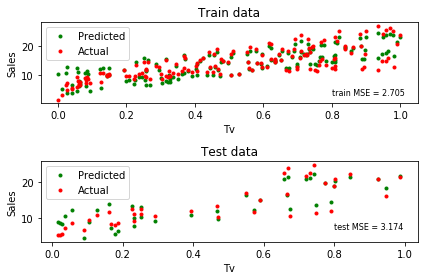

In [60]:
# plot least squares
# train data
plt.subplot(2,1,1)
plt.plot(X_train.TV, X_train.dot(A), 'g.')
plt.plot(X_train.TV, y_train, 'r.')

plt.legend(['Predicted', 'Actual'])
plt.xlabel('Tv')
plt.ylabel('Sales')
plt.title('Train data')
plt.text(0.8, 3, 'train MSE = {0}'.format(round(mse_train,3)), fontsize=8)
#plt.text("train MSE = {0} \n test MSE = {1}".format(mse_train, mse_test))
# test data
plt.subplot(2,1,2)
plt.plot(X_test.TV, X_test.dot(A), 'g.')
plt.plot(X_test.TV, y_test, 'r.')
plt.legend(['Predicted', 'Actual'])
plt.title('Test data')
plt.xlabel('Tv')
plt.ylabel('Sales')
plt.text(0.8, 7, 'test MSE = {0}'.format(round(mse_test,3)), fontsize=8)
plt.tight_layout()
#axs[1].title('Test data')
#.title('MSE vs TV for test and train data')
#plt.title('MSE vs TV for test and train data')

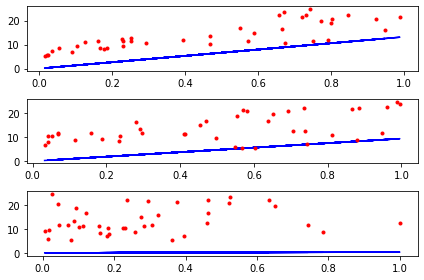

In [67]:
X, y = get_data()
X_normalised = X.apply(normalize_feature, axis=0)
X_train, X_test, y_train, y_test = get_train_test_data(X_normalised, y)
A = least_square(X_train, y_train)
cols = np.array(X_train.columns.drop('intercept'))
fig, axs = plt.subplots(len(cols))
for i,col in enumerate(cols):
    A_col = A[col]
    axs[i].plot(X_test[col], X_test[col].multiply(A_col), 'b')
    axs[i].plot(X_test[col], y_test, 'r.')
plt.tight_layout()

In [7]:
'''
split into training test
1) add one column
2) initialize x
3) compute derivative
4) set threshold
5) cutoff
'''

200